In [1]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
%pylab inline
import pandas as pd

merged = pd.read_csv("TableS4-WGSvsCapillary-combined.csv")

# Remove FXN, since no WGS calls
merged = merged[~merged["PrimerID"].isin(["FXN"])]

# Remove where we couldn't compare
merged = merged[merged["match.ensemble"].apply(str) != "nan"]

# Get dosages and check matches
def GetDosage(x):
    if x == "." or x == "./.": return np.nan
    else: return sum([int(float(item)) for item in x.split(",")])
    
merged["dosage.ensemble"] = merged["Ensemble"].apply(GetDosage)
merged["dosage.cap"] = merged["Cap.Binned"].apply(GetDosage)

Populating the interactive namespace from numpy and matplotlib


In [3]:
######## Output summary info ########
print("Number of loci: %s"%(len(set(merged["PrimerID"]))))
print("Number of samples: %s"%(len(set(merged["SampleID"]))))
print("Number of calls: %s"%(merged.shape[0]))

num_nonmissing = (merged[(merged["Ensemble"]!="./.") & (merged["Cap.Binned"]!= "./.")].shape[0])
num_correct = (np.sum(merged[(merged["Ensemble"]!="./.") & (merged["Cap.Binned"]!= "./.")]["match.ensemble"]))
print("Number of calls (not missing): %s"%num_nonmissing)
print("Number of correct: %s"%num_correct)
print("Concordance: %s"%(num_correct/num_nonmissing))

Number of loci: 45
Number of samples: 31
Number of calls: 1394
Number of calls (not missing): 1394
Number of correct: 1361
Concordance: 0.9763271162123386


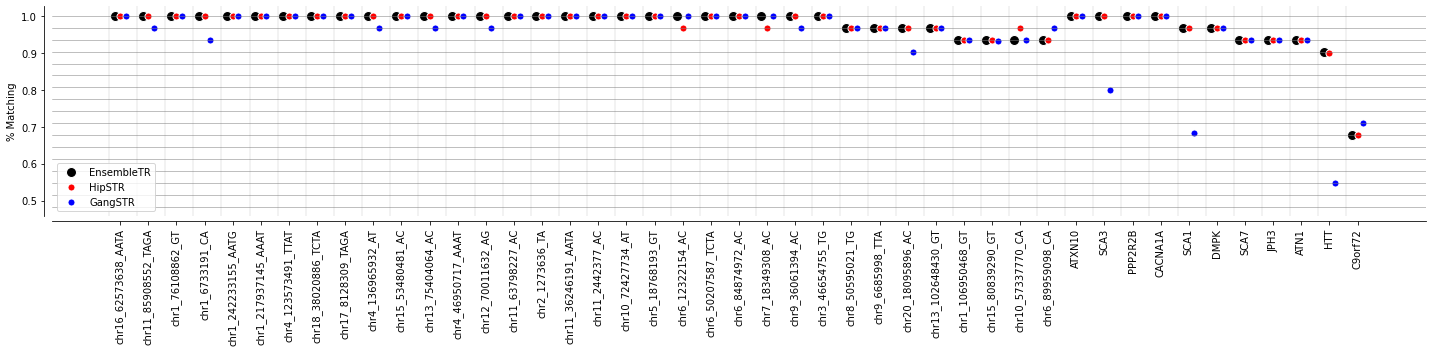

In [4]:
######## Per-locus accuracy ########
locdata = merged[merged["Ensemble"]!="./."].groupby(["PrimerID"], as_index=False).agg({"match.ensemble": np.sum, "SampleID": len})
locdata["ens.acc"] = locdata.apply(lambda x: x["match.ensemble"]/x["SampleID"], 1)
locdata = locdata.sort_values("ens.acc", ascending=False)

locdata_g = merged[merged["GangSTR"]!="./."].groupby(["PrimerID"], as_index=False).agg({"match.gangstr": np.sum, "SampleID": len})
locdata_g["gangstr.acc"] = locdata_g.apply(lambda x: x["match.gangstr"]/x["SampleID"], 1)
locdata_h = merged[merged["HipSTR"]!="./."].groupby(["PrimerID"], as_index=False).agg({"match.hipstr": np.sum, "SampleID": len})
locdata_h["hipstr.acc"] = locdata_h.apply(lambda x: x["match.hipstr"]/x["SampleID"], 1)

locdata = pd.merge(locdata, locdata_g[["PrimerID","gangstr.acc"]], how="left", on=["PrimerID"])
locdata = pd.merge(locdata, locdata_h[["PrimerID","hipstr.acc"]], how="left", on=["PrimerID"])
locdata["is.disease"] = locdata.apply(lambda x: x["PrimerID"].startswith("chr"), 1)
locdata = locdata.sort_values(["is.disease", "ens.acc"], ascending=False)


w = 0.2
fig = plt.figure()
fig.set_size_inches((20, 5))
ax = fig.add_subplot(111)
ax.scatter(range(locdata.shape[0]), locdata["ens.acc"], edgecolor="white", color='black', 
       label="EnsembleTR", s=100)
ax.scatter([item+w for item in range(locdata.shape[0])], locdata["hipstr.acc"], edgecolor="white", 
       color='red',label="HipSTR", s=50)
ax.scatter([item+2*w for item in range(locdata.shape[0])], locdata["gangstr.acc"], edgecolor="white", 
       color='blue', label="GangSTR", s=50)

for i in range((locdata.shape[0])):
    ax.axvline(x=i-w, linestyle="solid", color="gray", linewidth=0.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))
plt.rcParams['axes.linewidth']=0.8

ax.set_xticks([item+w for item in range(locdata.shape[0])])
ax.set_xticklabels(locdata["PrimerID"], rotation=90);
ax.set_ylabel("% Matching");
ax.legend(loc="lower left");

for num_corr in range(15, 32):
    ax.axhline(y=num_corr/31, linestyle="solid", color="gray", linewidth=0.5)
plt.tight_layout()
fig.savefig("pdfs/SuppFig-CapillaryLocusConcordance.pdf")

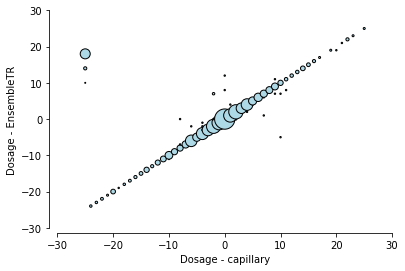

In [5]:
######## Bubbles ########

bubbles = merged[merged["Ensemble"]!="./."].groupby(["dosage.ensemble","dosage.cap"], as_index=False).agg({"SampleID": len})

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(bubbles["dosage.cap"], bubbles["dosage.ensemble"], 
           s=bubbles["SampleID"]*2, edgecolor="black", color="lightblue")
ax.scatter([-25, -25, -25], [10, 14, 18], s=[1, 10, 100], edgecolor="black", color="lightblue")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlim(left=-30, right=30)
ax.set_ylim(bottom=-30, top=30);
ax.set_xlabel("Dosage - capillary")
ax.set_ylabel("Dosage - EnsembleTR");
fig.savefig("pdfs/SuppFig-CapillaryBubbles.pdf")

In [6]:
######## Inspect discordant calls ########
# 46 discordant calls
# * 10 are C9orf72
# * 14 are off by one
# * 15 are het dropout
# * 7 are other 

"""

1477	C9orf72	NA19238	2,3	1,3
1476	C9orf72	NA18942	0,0	-1,-1
1458	C9orf72	HG00731	-1,8	-1,7
1473	C9orf72	NA18939	-2,-2	-1,-1
1472	C9orf72	NA18488	-1,11	-1,8
1471	C9orf72	NA12892	-1,2	2,2
1469	C9orf72	NA12890	-1,-1	-1,8
1468	C9orf72	NA12889	-1,-1	-1,8
1466	C9orf72	NA12877	-1,-1	-1,8
1460	C9orf72	HG00766	-1,10	-1,8

Off by one:
381	DMPK	HG00732	-16,-15	-15,-15
1491	HTT	HG00766	-2,-2	-2,-1
1512	HTT	NA20504	-1,-1	-1,0
507	SCA7	NA18488	1,1	0,1
548	chr10_57337770_CA	NA19434	-5,-5	-6,-5
818	chr15_80839290_GT	NA19238	9,11	8,11
1063	chr20_42508128_TG	NA20506	0,5	0,6
1330	chr6_89959098_CA	HG00766	-4,-4	-4,-3
1318	chr6_89959098_CA	NA19238	-1,-1	-1,0
1354	chr7_18349308_AC	NA18939	1,2	2,2
1357	chr7_27264534_AC	NA18488	-4,-1	-5,-1
1369	chr7_27264534_AC	NA20505	4,5	5,5
1403	chr8_50595021_TG	HG03736	0,3	0,2
0	ATN1	NA12892	0,2	0,1

Het dropout:
427	JPH3	NA19239	0,0	0,12
105	chr13_102648430_GT	NA12890	0,2	0,0
42	SCA1	NA12892	0,2	0,0
529	SCA7	NA18939	2,2	0,2
780	chr13_81527591_CTAT	HG00766	1,3	3,3
759	chr13_81527591_CTAT	NA18942	1,3	1,1
779	chr13_81527591_CTAT	NA18939	1,2	1,1
923	chr1_106950468_GT	NA19434	-3,-3	-3,1
918	chr1_106950468_GT	NA19238	-1,-1	-1,1
1046	chr20_18095896_AC	NA18940	5,5	-10,5
1072	chr20_42508128_TG	NA20846	1,4	1,1
1066	chr20_42508128_TG	HG01113	0,4	0,0
191	chr20_42508128_TG	NA12877	0,3	0,0
188	chr20_42508128_TG	NA12889	0,3	0,0
1434	chr9_6685998_TTA	NA18942	0,0	0,8

Other:
1488	HTT	HG00268	-2,9	-3,4
1505	HTT	NA18940	-2,-2	-5,-5
412	JPH3	NA20849	-4,-4	0,0
544	chr10_57337770_CA	NA20505	-3,-1	-1,0
810	chr15_80839290_GT	HG01119	2,7	4,7
1073	chr20_42508128_TG	NA19434	0,4	0,7
288	ATN1	NA20506	0,11	0,8

"""
merged[(merged["Ensemble"]!="./.") & (merged["match.ensemble"]==False)].sort_values("PrimerID")[["PrimerID","SampleID","Cap.Binned","Ensemble"]]

,PrimerID,SampleID,Cap.Binned,Ensemble
0,ATN1,NA12892,"0,2","0,1"
288,ATN1,NA20506,"0,11","0,8"
1477,C9orf72,NA19238,"2,3","1,3"
1476,C9orf72,NA18942,"0,0","-1,-1"
1473,C9orf72,NA18939,"-2,-2","-1,-1"
1472,C9orf72,NA18488,"-1,11","-1,8"
1471,C9orf72,NA12892,"-1,2","2,2"
1469,C9orf72,NA12890,"-1,-1","-1,8"
1468,C9orf72,NA12889,"-1,-1","-1,8"
1466,C9orf72,NA12877,"-1,-1","-1,8"


In [10]:
set(merged['PrimerID'])

{'ATN1',
 'ATXN10',
 'C9orf72',
 'CACNA1A',
 'DMPK',
 'HTT',
 'JPH3',
 'PPP2R2B',
 'SCA1',
 'SCA3',
 'SCA7',
 'chr10_57337770_CA',
 'chr10_72427734_AT',
 'chr11_2442377_AC',
 'chr11_36246191_AATA',
 'chr11_63798227_AC',
 'chr11_85908552_TAGA',
 'chr12_70011632_AG',
 'chr13_102648430_GT',
 'chr13_75404064_AC',
 'chr15_53480481_AC',
 'chr15_80839290_GT',
 'chr16_62573638_AATA',
 'chr17_8128309_TAGA',
 'chr18_38020886_TCTA',
 'chr1_106950468_GT',
 'chr1_217937145_AAAT',
 'chr1_242233155_AATG',
 'chr1_6733191_CA',
 'chr1_76108862_GT',
 'chr20_18095896_AC',
 'chr2_1273636_TA',
 'chr3_46654755_TG',
 'chr4_123573491_TTAT',
 'chr4_136965932_AT',
 'chr4_46950717_AAAT',
 'chr5_18768193_GT',
 'chr6_12322154_AC',
 'chr6_50207587_TCTA',
 'chr6_84874972_AC',
 'chr6_89959098_CA',
 'chr7_18349308_AC',
 'chr8_50595021_TG',
 'chr9_36061394_AC',
 'chr9_6685998_TTA'}